# Импорт необходимых модумей

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import locale
import re
import os
import logging

# Загрузка данных

In [2]:
# Настройка логирования для отслеживания выполнения кода
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Устанавливание рабочей директории
os.chdir("source/")

# Отображать все столбцы
pd.set_option('display.max_columns', None)

# Отображать все строки
pd.set_option('display.max_rows', None)


In [3]:
# Загрузка данных из CSV файлов
data_loan = pd.read_csv('ListPI1.csv')
data_app = pd.read_csv('ListP1.csv')
data_beh = pd.read_csv('ListB1.csv')


C:\Users\F_Jumaev\AppData\Local\Temp\ipykernel_6516\3632514673.py:2: DtypeWarning: Columns (17,18,25,26,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data_loan = pd.read_csv('ListPI1.csv')
C:\Users\F_Jumaev\AppData\Local\Temp\ipykernel_6516\3632514673.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data_beh = pd.read_csv('ListB1.csv')


# Преобразование названий столбцов в snake_case

In [4]:
# Функция для преобразования названий столбцов в snake_case
def to_snake_case(column_name):
    return column_name.lower().replace('.', '_').replace('#', 'number').replace(' ', '_')

logging.info("Преобразование названий столбцов в snake_case.")
data_loan.columns = [to_snake_case(col) for col in data_loan.columns]
data_app.columns = [to_snake_case(col) for col in data_app.columns]
data_beh.columns = [to_snake_case(col) for col in data_beh.columns]


2024-12-04 13:24:06,126 - INFO - Преобразование названий столбцов в snake_case.


# Переименование столбцов с русскими именами на английские

In [5]:
rename_columns = {
    'наличие_эсхата_онлайн': 'eskhata_online',
    'наличие_пластиковых_карт': 'plastic_cards',
    'наличие_депозита': 'deposit',
    'кумулятивная_просрочка': 'cumulative_delinquency',
    'рейтинг_бки': 'bki_rating',
    'количество_кредитов__в_бки_(заемщик)': 'bki_number_of_loans'
}
logging.info("Переименование столбцов с русскими именами на английские.")
data_loan.rename(columns=rename_columns, inplace=True)
data_app.rename(columns=rename_columns, inplace=True)
data_beh.rename(columns=rename_columns, inplace=True)


2024-12-04 13:24:06,143 - INFO - Переименование столбцов с русскими именами на английские.


# Подсчет количества дубликатов (не включая первую строку)

In [6]:
logging.info("Проверка дублирующихся строк по account_id")
display(data_loan.duplicated(subset='account_id').sum())
display(data_app.duplicated(subset='account_id').sum())
display(data_beh.duplicated(subset='account_id').sum())

logging.info("Проверка дублирующихся строк по customer_id")
display(data_loan.duplicated(subset='account_id').sum())
display(data_app.duplicated(subset='account_id').sum())
display(data_beh.duplicated(subset='account_id').sum())

logging.info("Подсчет количества дубликатов по application_id")
display(data_loan.duplicated(subset='application_id').sum())
display(data_app.duplicated(subset='application_id').sum())



2024-12-04 13:24:06,156 - INFO - Проверка дублирующихся строк по account_id


32801

0

0

2024-12-04 13:24:06,193 - INFO - Проверка дублирующихся строк по customer_id


32801

0

0

2024-12-04 13:24:06,225 - INFO - Подсчет количества дубликатов по application_id


136

0

# Удаление дубликатов

In [7]:
# Удаление дубликатов по account_id
logging.info("Удаление дубликатов по account_id.")
data_loan.drop_duplicates(subset='account_id', keep='first', inplace=True)

# Удаление дубликатов по application_id
logging.info("Удаление дубликатов по application_id.")
data_loan.drop_duplicates(subset='application_id', keep='first', inplace=True)


# # Удаление дубликатов по customer_id
# logging.info("Удаление дубликатов по customer_id.")
# data_loan.drop_duplicates(subset='customer_id_loan', keep='first', inplace=True)

2024-12-04 13:24:06,307 - INFO - Удаление дубликатов по account_id.
2024-12-04 13:24:06,424 - INFO - Удаление дубликатов по application_id.


# Объединение данных по account_id

In [8]:
logging.info("Объединение данных по 'account_id'.")
res = data_loan.merge(data_app, on="account_id", how="left", suffixes=('_loan', '_app'))
res = res.merge(data_beh, on="account_id", how="left", suffixes=('', '_beh'))


2024-12-04 13:24:06,573 - INFO - Объединение данных по 'account_id'.


# Удаление дублириющих переменных

In [9]:
res = res.drop(['application_id_app', 'customer_id_app', 'customer_id'], axis=1)
res = res.rename(columns={
    'customer_id_loan': 'customer_id',
    'application_id_loan': 'application_id'
})


# Переименование столбцов для удобства

In [10]:
logging.info("Переименование столбцов")
res['dependants'] = res['number_dependants']
res['months_at_current_address'] = res['number_months_at_current_address']
res['months_at_job'] = res['number_months_at_job']

2024-12-04 13:24:08,160 - INFO - Переименование столбцов


In [11]:
res.head()

,customer_id,application_id,account_id,date_of_birth,gender,city_of_living,region_of_living,city_of_registration,region_of_registration,work_phone_number,mobile_phone_number,education,marital_status,number_dependants,number_children,number_months_at_current_address,employment_type,employment_sector,employment_segment,number_months_at_job,net_main_income,source_of_main_income,additional_income,source_of_additional_income,reported_expenses,months_with_bank,current_exposure,client_type_,property_object,eskhata_online,plastic_cards,deposit,состояние,причина_отказа,branch_id,product_id,application_date,date_loan_granted,loan_amount,first_instalment_due_date,interest_rate,collateral_type,value_of_collateral,property_type/collateral_type,salary_payment_in_bank_account,loan_type,number_of_instalments,instalment_amount/min_instalment_amount,run_date,date_account_opened,current_balance,date_last_payment,date_final_payment,due_date,payment_amount,account_status,number_of_payments_in_arrears,cumulative_delinquency,amount_due_–_instalment,principal_amount,interest_accrued,outstanding_balance,arrears_amount,current_days_past_due,maximum_days_past_due,maximum_days_past_due_lifetime,default_flag,кол-во_пролонгации,bki_rating,bki_number_of_loans,ftd-1,ftd-2,ftd-3,ftd-4,dependants,months_at_current_address,months_at_job
0,2.512152e+10,764446/КР,3.561914e+10,1998-01-07 00:00:00,Женский,нохияи Фирдавси,Душанбе,Фирдавси,Душанбе,992000805085,NaN,Высшее,Не замужем,0,2,0,Имеет другой источник дохода,NaN,NaN,0,3121.36,Прочее,NaN,NaN,1272.0,36,0.0,0,Квартира,Да,Да,0.0,NaN,NaN,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ДУШАНБЕ",Карзхои гуногунмаксад,2021-10-19,2021-11-02,12300.0,2021-12-02,31.0,NaN,NaN,NaN,Нет,Многоцелевые кредиты_005_аннуитет,18.0,863.0,2023-06-30,2021-11-02,0.0,NaN,2023-04-20,NaN,NaN,Закрыт,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,0,0
1,8.471401e+08,766801/КР,3.573316e+10,1969-05-16 00:00:00,Мужской,Истаравшан,Вилояти Сугд,Истаравшан,Вилояти Сугд,992985675558,NaN,Среднее,Женат,2,2,6,Собственный бизнес,Самозанятость,Услуги транспорта,276,3800.00,Прочее,NaN,NaN,1500.0,143,4691.17,1,Дом,Нет,Нет,0.0,NaN,NaN,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ИСТАРАВШАН",Карзхои гуногунмаксад,2021-10-25,2021-11-01,20000.0,2021-12-01,30.0,1) Поручитель;,1) 0;,1) Поручитель;,Нет,Многоцелевые кредиты_005_аннуитет,24.0,1118.0,2023-06-30,2021-11-01,0.0,2023-04-26,2023-10-26,2023-06-01,1118.0,Закрыт,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,5.0,0.0,0.0,0.0,0.0,2,6,276
2,6.286580e+09,766319/КР,3.573691e+10,1991-03-02 00:00:00,Мужской,Истаравшан,Вилояти Сугд,Истаравшан,Вилояти Сугд,992988621755,NaN,Среднее,Женат,3,2,9,Собственный бизнес,Самозанятость,Услуги транспорта,60,3500.00,Прочее,NaN,NaN,1000.0,61,4301.47,1,Дом,Нет,Нет,0.0,NaN,NaN,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш.ИСТАРАВШАН",Карзхои гуногунмаксад,2021-10-25,2021-11-05,10000.0,2021-12-06,30.0,NaN,NaN,NaN,Нет,Многоцелевые кредиты_005_аннуитет,24.0,559.0,2023-06-30,2021-11-05,0.0,2023-04-03,2023-10-26,2023-06-05,559.0,Закрыт,NaN,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,NaN,0.0,NaN,2.0,0.0,1.0,0.0,7.0,3,9,60
3,1.493983e+10,766446/КР,3.574159e+10,1966-10-23 00:00:00,Мужской,Фархор,Вилояти Хатлон,Пархар,Вилояти Хатлон,+992900078418; ; ;,NaN,Среднее,Женат,1,2,39,Имеет другой источник дохода,NaN,NaN,0,2400.00,Доход семьи,NaN,NaN,1000.0,60,1153.52,1,Дом,Нет,Нет,0.0,NaN,NaN,"ФИЛИАЛИ ЧСК ""БОНКИ ЭСХАТА"" ДАР Ш. КУЛОБ",Карзхои гуногунмаксад,2021-10-25,2021-11-03,3300.0,2021-12-03,31.0,NaN,NaN,NaN,Нет,Многоцелевые кредиты_005_аннуитет,12.0,323.0,2023-06-30,2021-11-03,0.0,2022-09-12,2022-10-26,NaN,NaN,Закрыт,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,39,0
4,3.283014e+10,767392/КР,3.575473e+10,2001-06-07 00:00:00,Мужской,поселки Варзобского района,Нохияхои тобеи Чумхури,поселки Варзобского района,Нохияхои тобеи Чумхури,NaN,992888051515,Среднее,Холост,0,0,2,Собственный бизнес,Самозанятость,Услуги транспорта,36,5700.00,Предпринимательство,NaN,NaN,3001.0,20,49

In [12]:
# Создание копии датафрейма для дальнейшей обработки
df = res.copy()

# Преобразование необходимых столбцов в числовые значения

In [13]:
numeric_columns = [
    'net_main_income', 'additional_income', 'months_with_bank',
    'reported_expenses', 'deposit', 'current_exposure'
]
missing_numeric = [col for col in numeric_columns if col not in df.columns]
if missing_numeric:
    logging.warning(f"Отсутствуют следующие числовые столбцы: {missing_numeric}")

existing_numeric_columns = [col for col in numeric_columns if col in df.columns]
logging.info("Преобразование числовых столбцов в числовые значения.")
df[existing_numeric_columns] = df[existing_numeric_columns].apply(pd.to_numeric, errors='coerce')

2024-12-04 13:24:08,357 - INFO - Преобразование числовых столбцов в числовые значения.


In [14]:
# Преобразование столбцов с датами в формат datetime
date_columns = [
    'application_date', 'date_of_birth', 'date_loan_granted', 'first_instalment_due_date',
    'date_last_payment', 'date_final_payment', 'due_date', 'date_account_opened'
]
logging.info("Преобразование столбцов с датами в формат datetime.")
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')


2024-12-04 13:24:08,892 - INFO - Преобразование столбцов с датами в формат datetime.


In [15]:

# Вычисление возраста
logging.info("Вычисление возраста.")
# Оптимизированное вычисление возраста
df['age'] = df['application_date'].dt.year - df['date_of_birth'].dt.year
# Корректировка возраста, если месяц или день рождения еще не наступили в году заявки
df.loc[
    (df['application_date'].dt.month < df['date_of_birth'].dt.month) |
    ((df['application_date'].dt.month == df['date_of_birth'].dt.month) &
     (df['application_date'].dt.day < df['date_of_birth'].dt.day)),
    'age'
] -= 1
# Удаление отрицательных возрастов, если такие есть
df['age'] = df['age'].where(df['age'] >= 0, np.nan)

2024-12-04 13:24:10,023 - INFO - Вычисление возраста.


In [16]:

# Создание столбца loan_month как год * 100 + месяц
logging.info("Создание столбца 'loan_month'.")
df['loan_month'] = df['application_date'].dt.year * 100 + df['application_date'].dt.month

# Признак совпадения города проживания и регистрации
logging.info("Создание признака совпадения города проживания и регистрации.")
df['city_of_living_eq_registration'] = (df['city_of_living'] == df['city_of_registration']).astype(int)

# Признак наличия залога
logging.info("Создание признака наличия залога.")
df['is_collateral'] = df['deposit'].notna().astype(int)

2024-12-04 13:24:10,220 - INFO - Создание столбца 'loan_month'.
2024-12-04 13:24:10,258 - INFO - Создание признака совпадения города проживания и регистрации.
2024-12-04 13:24:10,282 - INFO - Создание признака наличия залога.


In [17]:
# Создание временного датафрейма для анализа предыдущих заявок
logging.info("Создание временного DataFrame для анализа предыдущих заявок.")
temp_df = df.copy()

# Сортировка по customer_id и application_date для корректного сдвига
logging.info("Сортировка по 'customer_id' и 'application_date'.")
temp_df = temp_df.sort_values(['customer_id', 'application_date'])

# Добавление предыдущей даты заявки и предыдущей максимальной просрочки
logging.info("Добавление предыдущей даты заявки и предыдущей максимальной просрочки.")
temp_df['prev_application_date'] = temp_df.groupby('customer_id')['application_date'].shift(1)
temp_df['prev_max_days_past_due'] = temp_df.groupby('customer_id')['maximum_days_past_due_lifetime'].shift(1)


# Убираем записи без предыдущих заявок
logging.info("Удаление записей без предыдущих заявок.")
temp_df = temp_df.dropna(subset=['prev_application_date'])

2024-12-04 13:24:10,301 - INFO - Создание временного DataFrame для анализа предыдущих заявок.
2024-12-04 13:24:10,423 - INFO - Сортировка по 'customer_id' и 'application_date'.
2024-12-04 13:24:10,842 - INFO - Добавление предыдущей даты заявки и предыдущей максимальной просрочки.
2024-12-04 13:24:10,914 - INFO - Удаление записей без предыдущих заявок.


In [18]:
# Группировка по account_id для подсчета количества предыдущих заявок и максимальной просрочки
logging.info("Группировка по 'account_id' для подсчета количества предыдущих заявок и максимальной просрочки.")
acc_numb_before = temp_df.groupby('account_id').agg(
    cnt=('customer_id', 'count'),
    max_max_days_past_due=('prev_max_days_past_due', 'max')
).reset_index()

logging.info("Пример данных после группировки:")
print("\nacc_numb_before.head():")
print(acc_numb_before.head())


2024-12-04 13:24:11,072 - INFO - Группировка по 'account_id' для подсчета количества предыдущих заявок и максимальной просрочки.
2024-12-04 13:24:11,097 - INFO - Пример данных после группировки:



acc_numb_before.head():
     account_id  cnt  max_max_days_past_due
0  3.600220e+10    1                    4.0
1  3.600311e+10    1                   17.0
2  3.603127e+10    1                    0.0
3  3.605477e+10    1                    3.0
4  3.606057e+10    1                    0.0


In [19]:
# Добавление флага существующего клиента
logging.info("Добавление флага существующего клиента.")
acc_numb_before['existing_client'] = np.where(acc_numb_before['cnt'] > 1, 1, 0)

# Объединение с основным датафреймом
logging.info("Объединение 'acc_numb_before' с основным DataFrame.")
df = df.merge(
    acc_numb_before[['account_id', 'cnt', 'max_max_days_past_due']], 
    on='account_id', 
    how='left'
)

2024-12-04 13:24:11,120 - INFO - Добавление флага существующего клиента.
2024-12-04 13:24:11,123 - INFO - Объединение 'acc_numb_before' с основным DataFrame.


In [20]:
# Проверка наличия столбца 'cnt' после объединения
logging.info("Проверка наличия столбца 'cnt' после объединения.")
print("\nСтолбцы после объединения acc_numb_before:")
print(df.columns.tolist())
if 'cnt' not in df.columns:
    logging.error("Столбец 'cnt' отсутствует в DataFrame после объединения. Проверьте корректность группировки и объединения.")
    raise KeyError("Столбец 'cnt' отсутствует в DataFrame после объединения.")
else:
    # Заполнение пропусков в previous_loans_count нулями
    logging.info("Заполнение пропусков в 'previous_loans_count' нулями.")
    df['previous_loans_count'] = df['cnt'].fillna(0).astype(int)
    
    # Создание бинарных признаков для просроченности с использованием .loc
    logging.info("Создание бинарных признаков для просроченности.")
    df.loc[:, 'gb_90ever'] = (df['maximum_days_past_due_lifetime'] >= 90).astype(int)
    df.loc[:, 'gb_cum_dlq_90'] = (df['cumulative_delinquency'] >= 90).astype(int)
    df.loc[:, 'gb_60ever'] = (df['maximum_days_past_due_lifetime'] >= 60).astype(int)
    
    # Удаление временных столбцов, если они больше не нужны
    logging.info("Удаление временных столбцов 'cnt' и 'max_max_days_past_due'.")
    df.drop(['cnt', 'max_max_days_past_due'], axis=1, inplace=True)

2024-12-04 13:24:11,603 - INFO - Проверка наличия столбца 'cnt' после объединения.
2024-12-04 13:24:11,606 - INFO - Заполнение пропусков в 'previous_loans_count' нулями.
2024-12-04 13:24:11,611 - INFO - Создание бинарных признаков для просроченности.
2024-12-04 13:24:11,618 - INFO - Удаление временных столбцов 'cnt' и 'max_max_days_past_due'.



Столбцы после объединения acc_numb_before:
['customer_id', 'application_id', 'account_id', 'date_of_birth', 'gender', 'city_of_living', 'region_of_living', 'city_of_registration', 'region_of_registration', 'work_phone_number', 'mobile_phone_number', 'education', 'marital_status', 'number_dependants', 'number_children', 'number_months_at_current_address', 'employment_type', 'employment_sector', 'employment_segment', 'number_months_at_job', 'net_main_income', 'source_of_main_income', 'additional_income', 'source_of_additional_income', 'reported_expenses', 'months_with_bank', 'current_exposure', 'client_type_', 'property_object', 'eskhata_online', 'plastic_cards', 'deposit', 'состояние', 'причина_отказа', 'branch_id', 'product_id', 'application_date', 'date_loan_granted', 'loan_amount', 'first_instalment_due_date', 'interest_rate', 'collateral_type', 'value_of_collateral', 'property_type/collateral_type', 'salary_payment_in_bank_account', 'loan_type', 'number_of_instalments', 'instalment

In [21]:


# Сводные статистики
logging.info("Сводные статистики по 'net_main_income'.")
print("\nСводные статистики по net_main_income:")
print(df['net_main_income'].describe())

logging.info("Сводные статистики по 'age'.")
print("\nСводные статистики по age:")
print(df['age'].describe())

logging.info("Сводные статистики по 'marital_status'.")
print("\nСводные статистики по marital_status:")
print(df['marital_status'].describe())

2024-12-04 13:24:11,790 - INFO - Сводные статистики по 'net_main_income'.
2024-12-04 13:24:11,807 - INFO - Сводные статистики по 'age'.
2024-12-04 13:24:11,822 - INFO - Сводные статистики по 'marital_status'.



Сводные статистики по net_main_income:
count    2.356630e+05
mean     5.173426e+03
std      4.147526e+05
min      1.000000e-02
25%      1.950000e+03
50%      2.787000e+03
75%      4.000000e+03
max      9.004431e+07
Name: net_main_income, dtype: float64

Сводные статистики по age:
count    235696.000000
mean         38.833540
std          12.371292
min           0.000000
25%          29.000000
50%          37.000000
75%          48.000000
max          94.000000
Name: age, dtype: float64

Сводные статистики по marital_status:
count     235424
unique         8
top        Женат
freq       99528
Name: marital_status, dtype: object


In [22]:

# Преобразование строковых переменных в категориальные
logging.info("Преобразование строковых переменных в категориальные.")
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns] = df[object_columns].astype('category')

2024-12-04 13:24:11,871 - INFO - Преобразование строковых переменных в категориальные.


In [23]:

# Просмотр структуры датафрейма после преобразований
logging.info("Просмотр структуры датафрейма после преобразований.")
print("\nСтруктура датафрейма после преобразований:")
print(df.info())
print("\nНазвания столбцов:")
print(df.columns.tolist())

2024-12-04 13:24:14,855 - INFO - Просмотр структуры датафрейма после преобразований.



Структура датафрейма после преобразований:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 235699 entries, 0 to 235698
Data columns (total 85 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   customer_id                              235699 non-null  float64       
 1   application_id                           235699 non-null  category      
 2   account_id                               235698 non-null  float64       
 3   date_of_birth                            235698 non-null  datetime64[ns]
 4   gender                                   235699 non-null  category      
 5   city_of_living                           235699 non-null  category      
 6   region_of_living                         235699 non-null  category      
 7   city_of_registration                     235699 non-null  category      
 8   region_of_registration                   235699 non-null  ca

In [24]:
# Выбор необходимых столбцов
include_vars_1 = [
    "customer_id",
    "account_id",
    # "branch_id",
    # "product_id",
    "loan_amount",
    # "collateral_type",
    "is_collateral",
    "salary_payment_in_bank_account",
    # "date_of_birth",
    "age",
    "gender",
    # "city_of_living",
    "region_of_living",
    # "city_of_registration",
    "region_of_registration",
    "city_of_living_eq_registration",
    "education",
    "marital_status",
    "dependants",
    "months_at_current_address",
    "employment_type",
    # "employment_sector",
    "employment_segment",
    "months_at_job",
    "net_main_income",
    "source_of_main_income",
    "additional_income",
    # "source_of_additional_income",
    "reported_expenses",
    "months_with_bank",
    # "current_exposure",
    "client_type_",
    "property_object",
    "eskhata_online",
    "plastic_cards",
    "deposit",
    "gb_90ever",
    "gb_cum_dlq_90",
    "gb_60ever",
    "bki_rating",
    "bki_number_of_loans",
    "loan_month",
    "previous_loans_count",
    "max_max_days_past_due"
]

In [25]:
# Проверка наличия всех столбцов
missing_columns = [col for col in include_vars_1 if col not in df.columns]
if missing_columns:
    logging.warning(f"Отсутствуют следующие столбцы: {missing_columns}")

2024-12-04 13:24:15,216 - WARNING - Отсутствуют следующие столбцы: ['max_max_days_past_due']


In [26]:
# Создание нового датафрейма с выбранными столбцами (только существующие)
existing_include_vars = [col for col in include_vars_1 if col in df.columns]
df_selected = df[existing_include_vars].copy()

In [27]:
# Группировка по loan_month и вычисление показателей просроченности
logging.info("Группировка по 'loan_month' и вычисление показателей просроченности.")
rep_gb_90ever_month = df_selected.groupby('loan_month').agg(
    count=('gb_90ever', 'count'),
    bad_num=('gb_90ever', 'sum'),
    bad_rate=('gb_90ever', 'mean')  # Более эффективный способ вычисления среднего
).reset_index()

rep_gb_cum_dlq_90_month = df_selected.groupby('loan_month').agg(
    count=('gb_cum_dlq_90', 'count'),
    bad_num=('gb_cum_dlq_90', 'sum'),
    bad_rate=('gb_cum_dlq_90', 'mean')
).reset_index()

rep_gb_60ever_month = df_selected.groupby('loan_month').agg(
    count=('gb_60ever', 'count'),
    bad_num=('gb_60ever', 'sum'),
    bad_rate=('gb_60ever', 'mean')
).reset_index()


2024-12-04 13:24:15,275 - INFO - Группировка по 'loan_month' и вычисление показателей просроченности.


In [28]:
# Создание выборок по типу занятости
logging.info("Создание выборок по типу занятости.")
sample_empl = df_selected[
    (df_selected['employment_type'] == "Работает в организации") &
    (df_selected['employment_segment'].isin([
        "Мед. работник",
        "Работник в сфере образования",
        "Работник госструктур",
        "Работник НПО (Ташкилоти Чамъияти)",
        "Работник производства",
        "Работник сельского хозяйство",
        "Работник частной организации",
        "Строитель",
        "Экономист"
    ]))
].copy()

sample_bus = df_selected[
    (df_selected['employment_type'] == "Собственный бизнес") &
    (df_selected['employment_segment'].isin([
        "Агро",
        "Производство",
        "Торговля",
        "Услуги",
        "Услуги Мастера",
        "Услуги транспорта"
    ]))
].copy()

sample_other = df_selected[
    (df_selected['employment_type'] == "Имеет другой источник дохода") &
    (df_selected['employment_segment'].isna())
].copy()

2024-12-04 13:24:15,351 - INFO - Создание выборок по типу занятости.


In [29]:
# Вывод размеров выборок
logging.info("Вывод размеров выборок.")
print(f"\nРазмер выборки для работников: {sample_empl.shape[0]}")
print(f"Размер выборки для бизнесменов: {sample_bus.shape[0]}")
print(f"Размер выборки для других источников дохода: {sample_other.shape[0]}")

2024-12-04 13:24:15,422 - INFO - Вывод размеров выборок.



Размер выборки для работников: 51547
Размер выборки для бизнесменов: 79305
Размер выборки для других источников дохода: 85248


In [30]:
# --------- Создание выборки для анализа ---------------------------

# Пример выбора выборки для анализа (можно переключаться между выборками)
sample = sample_empl.copy()
# sample = sample_bus.copy()
# sample = sample_other.copy()

logging.info("Структура выбранной выборки:")
print("\nСтруктура выбранной выборки:")
print(sample.info())

2024-12-04 13:24:15,440 - INFO - Структура выбранной выборки:



Структура выбранной выборки:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51547 entries, 8 to 235698
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   customer_id                     51547 non-null  float64 
 1   account_id                      51546 non-null  float64 
 2   loan_amount                     51546 non-null  float64 
 3   is_collateral                   51547 non-null  int32   
 4   salary_payment_in_bank_account  51546 non-null  category
 5   age                             51545 non-null  float64 
 6   gender                          51547 non-null  category
 7   region_of_living                51547 non-null  category
 8   region_of_registration          51547 non-null  category
 9   city_of_living_eq_registration  51547 non-null  int32   
 10  education                       48721 non-null  category
 11  marital_status                  51463 non-null  c

In [31]:
# -------------------- Определение целевой переменной -------------------------
# Создание переменной gb и присваивание значений из gb_60ever
logging.info("Создание целевой переменной 'gb'.")
sample.loc[:, 'gb'] = sample['gb_60ever']\

# sample.loc[:, 'gb'] = sample['gb_cum_dlq_90']

2024-12-04 13:24:15,476 - INFO - Создание целевой переменной 'gb'.


In [32]:

# ------- Семплирование ---------------------------------------------------

# Создание выборок для обучения и тестирования

# Development Sample - выборка для обучения модели
dev = sample[(sample['loan_month'] >= 202110) & (sample['loan_month'] < 202210)].drop(columns=['loan_month']).copy()

# Out-of-time - выборка для тестирования модели на временную устойчивость
oot = sample[(sample['loan_month'] >= 202210) & (sample['loan_month'] < 202303)].copy()

# Out-of-time 2 - выборка для кросс-валидации внутри обучающей выборки
oot2 = sample[(sample['loan_month'] >= 202207) & (sample['loan_month'] < 202210)].copy()

# Development Final - выборка для финального обучения модели после тестирования
dev_final = sample[(sample['loan_month'] >= 202110) & (sample['loan_month'] < 202302)].drop(columns=['loan_month']).copy()

In [33]:
# Изучение распределений
logging.info("Изучение распределений в выборках.")
print("\nРаспределение в Development Sample:")
print(dev[['gb']].agg(['count', 'sum']))
print(dev[['gb']].agg(['count', 'sum']) / len(dev))

print("\nРаспределение в Out-of-time Sample:")
print(oot[['gb']].agg(['count', 'sum']))
print(oot[['gb']].agg(['count', 'sum']) / len(oot))

print("\nРаспределение в Out-of-time 2 Sample:")
print(oot2[['gb']].agg(['count', 'sum']))
print(oot2[['gb']].agg(['count', 'sum']) / len(oot2))

print("\nРаспределение в Development Final Sample:")
print(dev_final[['gb']].agg(['count', 'sum']))
print(dev_final[['gb']].agg(['count', 'sum']) / len(dev_final))

2024-12-04 13:24:15,540 - INFO - Изучение распределений в выборках.



Распределение в Development Sample:
          gb
count  27834
sum      599
            gb
count  1.00000
sum    0.02152

Распределение в Out-of-time Sample:
          gb
count  12429
sum       80
             gb
count  1.000000
sum    0.006437

Распределение в Out-of-time 2 Sample:
         gb
count  9355
sum     139
             gb
count  1.000000
sum    0.014858

Распределение в Development Final Sample:
          gb
count  37636
sum      669
             gb
count  1.000000
sum    0.017776


In [34]:
# Вывод количества строк в каждой выборке
logging.info("Вывод количества строк в каждой выборке.")
print(f"\nКоличество строк в Development Sample: {dev.shape[0]}")
print(f"Количество строк в Out-of-time Sample: {oot.shape[0]}")
print(f"Количество строк в Out-of-time 2 Sample: {oot2.shape[0]}")
print(f"Количество строк в Development Final Sample: {dev_final.shape[0]}")


2024-12-04 13:24:15,580 - INFO - Вывод количества строк в каждой выборке.



Количество строк в Development Sample: 27834
Количество строк в Out-of-time Sample: 12429
Количество строк в Out-of-time 2 Sample: 9355
Количество строк в Development Final Sample: 37636


In [48]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import json
import statsmodels.api as sm
import joblib



In [51]:
# -------------- Шаг 1: Расчет Information Value (IV) для dev_final --------------

logging.info("Расчет Information Value (IV) для всех переменных в dev_final.")
# Рассчитываем IV для dev_final
iv_values_final = sc.iv(dt=dev_final, y='gb')

# Просмотр структуры и первых строк DataFrame iv_values_final
print("Структура iv_values_final:")
print(iv_values_final.columns)

print("\nПервые 5 строк iv_values_final:")
print(iv_values_final.head())


2024-12-04 13:38:50,655 - INFO - Расчет Information Value (IV) для всех переменных в dev_final.


Структура iv_values_final:
Index(['variable', 'info_value'], dtype='object')

Первые 5 строк iv_values_final:
             variable  info_value
17          gb_60ever   17.210712
10      gb_cum_dlq_90    7.762180
23          gb_90ever    6.407824
30  additional_income    2.209887
19        loan_amount    1.865620


In [61]:
# -------------- Шаг 2: Отбор переменных на основе IV --------------

logging.info("Отбор переменных на основе IV >= 0.01.")
# Отбор переменных с info_value >= 0.01
selected_vars_iv = iv_values_final[
    iv_values_final['info_value'] >= 0.01
]['variable'].tolist()

logging.info(f"Переменные с info_value >= 0.01: {selected_vars_iv}")


2024-12-04 13:43:02,351 - INFO - Отбор переменных на основе IV >= 0.01.
2024-12-04 13:43:02,354 - INFO - Переменные с info_value >= 0.01: ['gb_60ever', 'gb_cum_dlq_90', 'gb_90ever', 'additional_income', 'loan_amount', 'reported_expenses', 'net_main_income', 'months_at_job', 'deposit', 'bki_number_of_loans', 'months_with_bank', 'age', 'employment_segment', 'marital_status', 'months_at_current_address', 'client_type_', 'bki_rating', 'customer_id', 'salary_payment_in_bank_account', 'region_of_living', 'dependants', 'region_of_registration', 'education', 'eskhata_online', 'gender', 'property_object', 'city_of_living_eq_registration', 'source_of_main_income', 'plastic_cards', 'previous_loans_count']


In [62]:
# -------------- Шаг 3: Рассчет доли пропусков для отобранных переменных --------------

logging.info("Расчет доли пропусков для отобранных переменных.")
# Рассчитываем долю пропусков для отобранных переменных
missing_rates = dev_final[selected_vars_iv].isnull().mean().reset_index()
missing_rates.columns = ['variable', 'missing']

# Просмотр первых строк
print("Структура missing_rates:")
print(missing_rates.columns)

print("\nПервые 5 строк missing_rates:")
print(missing_rates.head())


2024-12-04 13:43:02,873 - INFO - Расчет доли пропусков для отобранных переменных.


Структура missing_rates:
Index(['variable', 'missing'], dtype='object')

Первые 5 строк missing_rates:
            variable   missing
0          gb_60ever  0.000000
1      gb_cum_dlq_90  0.000000
2          gb_90ever  0.000000
3  additional_income  0.545382
4        loan_amount  0.000000


In [63]:
# -------------- Шаг 4: Объединение IV и missing_rates --------------

# Объединяем IV и долю пропусков
iv_with_missing = iv_values_final.merge(missing_rates, on='variable')

# Просмотр первых строк
print("Структура iv_with_missing:")
print(iv_with_missing.columns)

print("\nПервые 5 строк iv_with_missing:")
print(iv_with_missing.head())


Структура iv_with_missing:
Index(['variable', 'info_value', 'missing'], dtype='object')

Первые 5 строк iv_with_missing:
            variable  info_value   missing
0          gb_60ever   17.210712  0.000000
1      gb_cum_dlq_90    7.762180  0.000000
2          gb_90ever    6.407824  0.000000
3  additional_income    2.209887  0.545382
4        loan_amount    1.865620  0.000000


In [64]:
# -------------- Шаг 5: Фильтрация переменных по IV и пропускам --------------

logging.info("Фильтрация переменных по info_value >= 0.01 и missing <= 0.95.")
# Отбор переменных с info_value >= 0.01 и пропусками <= 0.95
filtered_iv = iv_with_missing[
    (iv_with_missing['info_value'] >= 0.01) &
    (iv_with_missing['missing'] <= 0.95)
]

# Извлечение списка переменных
selected_vars_final = filtered_iv['variable'].tolist()

# Исключение вручную определенных переменных
vars_to_remove = ["customer_id_x", "account_id", "gb_90ever", "gb_60ever", "gb_cum_dlq_90", "current_exposure"]
selected_vars_final = [var for var in selected_vars_final if var not in vars_to_remove]

logging.info(f"Отобранные переменные после фильтрации по IV и пропускам: {selected_vars_final}")


2024-12-04 13:43:03,879 - INFO - Фильтрация переменных по info_value >= 0.01 и missing <= 0.95.
2024-12-04 13:43:03,883 - INFO - Отобранные переменные после фильтрации по IV и пропускам: ['additional_income', 'loan_amount', 'reported_expenses', 'net_main_income', 'months_at_job', 'deposit', 'bki_number_of_loans', 'months_with_bank', 'age', 'employment_segment', 'marital_status', 'months_at_current_address', 'client_type_', 'bki_rating', 'customer_id', 'salary_payment_in_bank_account', 'region_of_living', 'dependants', 'region_of_registration', 'education', 'eskhata_online', 'gender', 'property_object', 'city_of_living_eq_registration', 'source_of_main_income', 'plastic_cards', 'previous_loans_count']


In [65]:
# -------------- Шаг 6: Создание dev_final_sel --------------

logging.info("Создание dev_final_sel с отобранными переменными.")
# Создание dev_final_sel с отобранными переменными
dev_final_sel = dev_final[selected_vars_final + ['gb']].copy()

logging.info(f"Количество строк в dev_final_sel: {dev_final_sel.shape[0]}")
logging.info(f"Количество столбцов в dev_final_sel: {dev_final_sel.shape[1]}")



2024-12-04 13:43:04,503 - INFO - Создание dev_final_sel с отобранными переменными.
2024-12-04 13:43:04,512 - INFO - Количество строк в dev_final_sel: 37636
2024-12-04 13:43:04,513 - INFO - Количество столбцов в dev_final_sel: 28


In [66]:
# -------------- Шаг 7: Определение правил биннинга --------------

logging.info("Определение правил биннинга для переменных.")

breaks = {
    'education': [
        "Высшее", "Ученая степень", "2 и более высших",
        "Среднее", "Начальное",
        "Среднее специальное",
        "Неоконченное высшее"
    ],
    'region_of_living': [
        "Вилояти Сугд", 
        "Вилояти Хатлон", "ВМКБ",
        "Душанбе", 
        "Нохияхои тобеи Чумхури"
    ],
    'marital_status': [
        "Женат", "Сожитель",
        "Замужем", "Вдова", "Разведена",
        "Холост", 
        "Не замужем", "Разведен"
    ],
    'employment_segment': [
        "Мед. работник", "Работник в сфере образования", "Экономист", "Работник НПО (Ташкилоти Чамъияти)",
        "Работник госструктур", "Строитель",
        "Работник производства", "Работник сельского хозяйство",
        "Работник частной организации"
    ],
    'source_of_main_income': [
        "Доход семьи",
        "Зарплата по основному месту работы",
        "Предпринимательство",
        "Пенсия", "Алименты", "Прочее", "missing"
    ],
    'months_at_job': [31, 61, 145, 277],
    'months_with_bank': [10, 25, 79],
    'net_main_income': ["missing", "1600", 3400]
}


2024-12-04 13:43:05,436 - INFO - Определение правил биннинга для переменных.


In [69]:
# -------------- Шаг 8: Применение биннинга и расчет WOE --------------

# 1. Обработка пропусков в категориальных переменных: добавление категории 'missing'
logging.info("Обработка пропусков в категориальных переменных.")
for var in selected_vars_final:
    if dev_final_sel[var].dtype == 'object' or pd.api.types.is_categorical_dtype(dev_final_sel[var]):
        if dev_final_sel[var].isnull().any():
            dev_final_sel[var] = dev_final_sel[var].astype('category')
            if 'missing' not in dev_final_sel[var].cat.categories:
                dev_final_sel[var].cat.add_categories('missing', inplace=True)
            dev_final_sel[var].fillna('missing', inplace=True)

logging.info("Применение биннинга и расчет WOE на dev_final_sel.")
try:
    bins_final5_M1_Employee = sc.woebin(
        dt=dev_final_sel,
        y="gb",
        method="tree",
        breaks_list=breaks,
        check_cate_num=False,
        count_distr_limit=0.05,
        bin_num_limit=5
    )
    logging.info("Биннинг и расчет WOE выполнены успешно.")
except Exception as e:
    logging.error(f"Ошибка при биннинге и расчете WOE: {e}")
    raise

2024-12-04 13:44:41,403 - INFO - Обработка пропусков в категориальных переменных.
C:\Users\F_Jumaev\AppData\Local\Temp\ipykernel_6516\3735736292.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  dev_final_sel[var].cat.add_categories('missing', inplace=True)
C:\Users\F_Jumaev\AppData\Local\Temp\ipykernel_6516\3735736292.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  dev_final_sel[var].cat.add_categories('missing', inplace=True)
C:\Users\F_Jumaev\AppData\Local\Temp\ipykernel_6516\3735736292.py:10: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always re

[INFO] creating woe binning ...


2024-12-04 13:44:53,749 - INFO - Биннинг и расчет WOE выполнены успешно.


Binning on 37636 rows and 28 columns in 00:00:12


In [77]:
# -------------- Сохранение результатов биннинга --------------

logging.info("Сохранение результатов биннинга в JSON и Excel.")
try:
    # Альтернативное сохранение биннинга в JSON вручную
    with open("M1_Employee_bins5.json", "w", encoding='utf-8') as f:
        # Преобразуем объекты pandas DataFrame в словари для JSON
        bins_json = {var: bins.to_dict(orient='records') for var, bins in bins_final5_M1_Employee.items()}
        json.dump(bins_json, f, ensure_ascii=False, indent=4)
    logging.info("Биннинг сохранён вручную в JSON формате.")
except Exception as e:
    logging.error(f"Ошибка при сохранении биннинга в JSON: {e}")
    raise

# Сохранение биннинга в Excel
try:
    with pd.ExcelWriter("M1_Employee_bins5.xlsx") as writer:
        for var, bins in bins_final5_M1_Employee.items():
            # Ограничение на длину имени листа в Excel (максимум 31 символ)
            sheet_name = var[:31]
            bins.to_excel(writer, sheet_name=sheet_name)
    logging.info("Биннинг сохранён в Excel формате.")
except Exception as e:
    logging.error(f"Ошибка при сохранении биннинга в Excel: {e}")
    raise

# Визуализация биннинга для одной из переменных (например, loan_amount)
var_to_plot = 'loan_amount'  # Замените на актуальное имя переменной
if var_to_plot in bins_final5_M1_Employee:
    logging.info(f"Визуализация биннинга для переменной '{var_to_plot}'.")
    try:
        # Передача аргументов как позиционных
        sc.woebin_plot(bins_final5_M1_Employee, var_to_plot, 1)
        plt.show()
    except Exception as e:
        logging.error(f"Ошибка при визуализации биннинга для переменной '{var_to_plot}': {e}")
else:
    logging.warning(f"Переменная '{var_to_plot}' не найдена в биннинге. Проверьте правильность имени.")

2024-12-04 13:51:15,197 - INFO - Сохранение результатов биннинга в JSON и Excel.
2024-12-04 13:51:15,227 - INFO - Биннинг сохранён вручную в JSON формате.
2024-12-04 13:51:16,626 - INFO - Биннинг сохранён в Excel формате.
2024-12-04 13:51:16,626 - INFO - Визуализация биннинга для переменной 'loan_amount'.
2024-12-04 13:51:16,673 - ERROR - Ошибка при визуализации биннинга для переменной 'loan_amount': 0


In [82]:

# -------------- Шаг 9: Разбиение данных на Train и Test --------------

logging.info("Разбиение данных на Train и Test (Out-of-sample).")
train, test = train_test_split(
    dev_final_sel,
    test_size=0.33,
    random_state=30,
    stratify=dev_final_sel['gb']
)

logging.info(f"Количество строк в Train: {train.shape[0]}")
logging.info(f"Количество строк в Test: {test.shape[0]}")


2024-12-04 13:56:38,486 - INFO - Разбиение данных на Train и Test (Out-of-sample).
2024-12-04 13:56:38,521 - INFO - Количество строк в Train: 25216
2024-12-04 13:56:38,522 - INFO - Количество строк в Test: 12420


In [83]:
# -------------- Шаг 10: Применение WOE кодирования к всем выборкам --------------

logging.info("Применение WOE кодирования к всем выборкам.")
dev_woe = sc.woebin_ply(dev, bins_final5_M1_Employee)
oot_woe = sc.woebin_ply(oot, bins_final5_M1_Employee)
oot2_woe = sc.woebin_ply(oot2, bins_final5_M1_Employee)

train_woe = sc.woebin_ply(train, bins_final5_M1_Employee)
test_woe = sc.woebin_ply(test, bins_final5_M1_Employee)

# Для финального полного обучающего семпла
dev_final_woe = sc.woebin_ply(dev_final_sel, bins_final5_M1_Employee)

# Для всего семпла
sample_woe = sc.woebin_ply(sample, bins_final5_M1_Employee)

2024-12-04 13:56:49,448 - INFO - Применение WOE кодирования к всем выборкам.


[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

In [85]:
# -------------- Шаг 11: Расчет Information Value для WOE-переменных --------------

logging.info("Расчет Information Value для WOE-переменных.")
iv_values_final_woe = sc.iv(dt=dev_final_woe, y='gb')

# Просмотр структуры и первых строк IV для WOE-переменных
print("Структура iv_values_final_woe:")
print(iv_values_final_woe.columns)

print("\nПервые 5 строк iv_values_final_woe:")
print(iv_values_final_woe.head())

# Сохранение IV значений
iv_values_final_woe.to_excel("M1_Employee_iv_values_woe_5.xlsx", index=False)

2024-12-04 13:58:05,102 - INFO - Расчет Information Value для WOE-переменных.


Структура iv_values_final_woe:
Index(['variable', 'info_value'], dtype='object')

Первые 5 строк iv_values_final_woe:
                  variable  info_value
10       months_at_job_woe    0.407732
11    months_with_bank_woe    0.381764
5                  age_woe    0.356403
13  employment_segment_woe    0.346704
2       marital_status_woe    0.274859


In [86]:
# -------------- Шаг 12: Проверка корреляции между признаками --------------

logging.info("Расчет корреляционной матрицы.")
cor_matrix = dev_final_woe[selected_vars_final].corr()

# Сохранение корреляционной матрицы в Excel
cor_matrix.to_excel("M1_Employee_corrM.xlsx")

# Визуализация корреляционной матрицы
logging.info("Визуализация корреляционной матрицы.")
plt.figure(figsize=(12, 10))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()


2024-12-04 13:58:16,759 - INFO - Расчет корреляционной матрицы.


KeyError: "None of [Index(['additional_income', 'loan_amount', 'reported_expenses',\n       'net_main_income', 'months_at_job', 'deposit', 'bki_number_of_loans',\n       'months_with_bank', 'age', 'employment_segment', 'marital_status',\n       'months_at_current_address', 'client_type_', 'bki_rating',\n       'customer_id', 'salary_payment_in_bank_account', 'region_of_living',\n       'dependants', 'region_of_registration', 'education', 'eskhata_online',\n       'gender', 'property_object', 'city_of_living_eq_registration',\n       'source_of_main_income', 'plastic_cards', 'previous_loans_count'],\n      dtype='object')] are in the [columns]"

In [87]:

# -------------- Шаг 13: Пошаговый отбор переменных (Stepwise Selection) --------------

# Функция для пошагового отбора переменных на основе p-значений
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out=0.05, 
                       verbose=True):
    """Пошаговый отбор переменных на основе p-значений."""
    included = list(initial_list)
    while True:
        changed=False
        # Добавление переменной
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            try:
                model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=0)
                new_pval[new_column] = model.pvalues[new_column]
            except:
                new_pval[new_column] = 1
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print(f'Добавлена переменная {best_feature} с p-value {best_pval}')
        # Удаление переменной
        if len(included) > 0:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
            pvalues = model.pvalues.drop('const')
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print(f'Удалена переменная {worst_feature} с p-value {worst_pval}')
        if not changed:
            break
    return included


In [88]:
# Разделение данных на признаки и целевую переменную
logging.info("Разделение данных на признаки и целевую переменную.")
X_train = train_woe.drop(['gb'], axis=1)
y_train = train_woe['gb']

# Пошаговый отбор переменных на основе p-значений
logging.info("Пошаговый отбор переменных на основе p-значений.")
selected_features_stepwise = stepwise_selection(X_train, y_train)

logging.info(f"Отобранные переменные после пошагового отбора: {selected_features_stepwise}")

2024-12-04 13:59:20,687 - INFO - Разделение данных на признаки и целевую переменную.
2024-12-04 13:59:20,696 - INFO - Пошаговый отбор переменных на основе p-значений.


Добавлена переменная months_with_bank_woe с p-value 1.3101491783370216e-35
Добавлена переменная age_woe с p-value 1.7717746251250655e-21
Добавлена переменная loan_amount_woe с p-value 1.2827055001349888e-16
Добавлена переменная employment_segment_woe с p-value 1.6077281570909377e-13
Добавлена переменная bki_rating_woe с p-value 1.2732510137686771e-11
Добавлена переменная months_at_job_woe с p-value 2.393494087739233e-05
Добавлена переменная salary_payment_in_bank_account_woe с p-value 0.0004032510414331804
Добавлена переменная education_woe с p-value 0.0010293365197366739
Добавлена переменная region_of_living_woe с p-value 0.009212340765310897
Добавлена переменная reported_expenses_woe с p-value 0.017299886177405698
Добавлена переменная gender_woe с p-value 0.023907215956554585
Добавлена переменная eskhata_online_woe с p-value 0.03469970275413535
Добавлена переменная additional_income_woe с p-value 0.04757877585506615


2024-12-04 13:59:31,883 - INFO - Отобранные переменные после пошагового отбора: ['months_with_bank_woe', 'age_woe', 'loan_amount_woe', 'employment_segment_woe', 'bki_rating_woe', 'months_at_job_woe', 'salary_payment_in_bank_account_woe', 'education_woe', 'region_of_living_woe', 'reported_expenses_woe', 'gender_woe', 'eskhata_online_woe', 'additional_income_woe']


In [89]:
# -------------- Шаг 14: Обучение модели с отобранными переменными --------------

logging.info("Обучение модели с отобранными переменными.")
X_train_selected = X_train[selected_features_stepwise]
model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)

2024-12-04 13:59:44,089 - INFO - Обучение модели с отобранными переменными.


LogisticRegression(max_iter=1000)

In [90]:
# Вывод коэффициентов модели
logging.info("Коэффициенты модели с отобранными переменными:")
coefficients_selected = pd.DataFrame({
    'Variable': selected_features_stepwise,
    'Coefficient': model_selected.coef_[0]
})
print(coefficients_selected)

2024-12-04 13:59:55,561 - INFO - Коэффициенты модели с отобранными переменными:


                              Variable  Coefficient
0                 months_with_bank_woe     0.647879
1                              age_woe     0.567706
2                      loan_amount_woe     1.234241
3               employment_segment_woe     0.408244
4                       bki_rating_woe     0.842064
5                    months_at_job_woe     0.406365
6   salary_payment_in_bank_account_woe     0.554517
7                        education_woe     0.506950
8                 region_of_living_woe     0.364565
9                reported_expenses_woe     0.732279
10                          gender_woe     0.490954
11                  eskhata_online_woe     0.445015
12               additional_income_woe     0.749831


In [91]:
# -------------- Шаг 15: Подготовка данных для предсказания --------------

# Обучение и сохранение scaler и imputer
logging.info("Обучение SimpleImputer и StandardScaler.")
# Обучение импьютера на тренировочных данных
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train_selected)

# Обучение скейлера на импутиванных данных
X_train_imputed = imputer.transform(X_train_selected)
scaler = StandardScaler()
scaler.fit(X_train_imputed)

# Сохранение scaler и imputer
logging.info("Сохранение scaler и imputer на диск.")
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')

2024-12-04 14:00:16,915 - INFO - Обучение SimpleImputer и StandardScaler.
2024-12-04 14:00:16,936 - INFO - Сохранение scaler и imputer на диск.


['imputer.joblib']

In [92]:
# Загрузка scaler и imputer (если необходимо)
# scaler = joblib.load('scaler.joblib')
# imputer = joblib.load('imputer.joblib')

# Функция для подготовки данных перед предсказанием
def prepare_data(df, bins, selected_features, scaler, imputer):
    """
    Применяет WOE кодирование, обработку пропусков и масштабирование к данным.
    """
    # Применение WOE кодирования
    df_woe = sc.woebin_ply(df, bins)
    
    # Выбор отобранных признаков
    X = df_woe[selected_features]
    
    # Обработка пропусков
    X_imputed = imputer.transform(X)
    
    # Масштабирование
    X_scaled = scaler.transform(X_imputed)
    
    return X_scaled

In [93]:
# Применение функции подготовки данных к различным выборкам
logging.info("Подготовка данных для предсказания на различных подвыборках.")

X_train_selected_scaled = prepare_data(train, bins_final5_M1_Employee, selected_features_stepwise, scaler, imputer)
y_train_selected = train['gb']

X_test_selected_scaled = prepare_data(test, bins_final5_M1_Employee, selected_features_stepwise, scaler, imputer)
y_test_selected = test['gb']

X_oot_selected_scaled = prepare_data(oot, bins_final5_M1_Employee, selected_features_stepwise, scaler, imputer)
y_oot_selected = oot['gb']

X_oot2_selected_scaled = prepare_data(oot2, bins_final5_M1_Employee, selected_features_stepwise, scaler, imputer)
y_oot2_selected = oot2['gb']

X_dev_final_selected_scaled = prepare_data(dev_final, bins_final5_M1_Employee, selected_features_stepwise, scaler, imputer)
y_dev_final_selected = dev_final['gb']



2024-12-04 14:00:49,300 - INFO - Подготовка данных для предсказания на различных подвыборках.


[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

[INFO] converting into woe values ...


C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtx.loc[:,x_i] = dtx.loc[:,x_i].astype(str).replace('nan', 'missing')
C:\Users\F_Jumaev\AppData\Roaming\Python\Python310\site-packages\scorecardpy\woebin.py:1059: S

In [94]:
# -------------- Шаг 16: Предсказания и оценка модели --------------

# Функция для оценки модели
def evaluate_model(y_true, y_pred, y_pred_proba, dataset_name):
    """
    Выводит ROC-AUC, отчет по классификации и матрицу ошибок.
    """
    auc = roc_auc_score(y_true, y_pred_proba)
    logging.info(f"ROC-AUC на {dataset_name} выборке: {auc:.4f}")
    print(f"\nОтчёт по классификации на {dataset_name} выборке:")
    print(classification_report(y_true, y_pred))
    print(f"Матрица ошибок на {dataset_name} выборке:")
    print(confusion_matrix(y_true, y_pred))
    return auc


In [95]:
# Предсказания на различных подвыборках
logging.info("Предсказания на тренировочной выборке.")
train_pred_proba = model_selected.predict_proba(X_train_selected_scaled)[:, 1]
train_pred = model_selected.predict(X_train_selected_scaled)

logging.info("Предсказания на тестовой выборке (out-of-sample).")
test_pred_proba = model_selected.predict_proba(X_test_selected_scaled)[:, 1]
test_pred = model_selected.predict(X_test_selected_scaled)

logging.info("Предсказания на out-of-time выборке.")
oot_pred_proba = model_selected.predict_proba(X_oot_selected_scaled)[:, 1]
oot_pred = model_selected.predict(X_oot_selected_scaled)

logging.info("Предсказания на out-of-time 2 выборке.")
oot2_pred_proba = model_selected.predict_proba(X_oot2_selected_scaled)[:, 1]
oot2_pred = model_selected.predict(X_oot2_selected_scaled)

logging.info("Предсказания на Development Final выборке.")
dev_final_pred_proba = model_selected.predict_proba(X_dev_final_selected_scaled)[:, 1]
dev_final_pred = model_selected.predict(X_dev_final_selected_scaled)


2024-12-04 14:01:35,520 - INFO - Предсказания на тренировочной выборке.
C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2024-12-04 14:01:35,531 - INFO - Предсказания на тестовой выборке (out-of-sample).
C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
2024-12-04 14:01:35,535 - INFO - Предсказания на out-of-time выборке.
C:\ProgramData\anaconda3\lib\site-packa

In [96]:
# Оценка модели на различных подвыборках
auc_train = evaluate_model(y_train_selected, train_pred, train_pred_proba, "тренировочной")
auc_test = evaluate_model(y_test_selected, test_pred, test_pred_proba, "тестовой (out-of-sample)")
auc_oot = evaluate_model(y_oot_selected, oot_pred, oot_pred_proba, "out-of-time")
auc_oot2 = evaluate_model(y_oot2_selected, oot2_pred, oot2_pred_proba, "out-of-time 2")
auc_dev_final = evaluate_model(y_dev_final_selected, dev_final_pred, dev_final_pred_proba, "Development Final")


2024-12-04 14:01:46,325 - INFO - ROC-AUC на тренировочной выборке: 0.7778
2024-12-04 14:01:46,366 - INFO - ROC-AUC на тестовой (out-of-sample) выборке: 0.7985
2024-12-04 14:01:46,399 - INFO - ROC-AUC на out-of-time выборке: 0.7814
2024-12-04 14:01:46,415 - INFO - ROC-AUC на out-of-time 2 выборке: 0.8042
2024-12-04 14:01:46,426 - INFO - ROC-AUC на Development Final выборке: 0.7846



Отчёт по классификации на тренировочной выборке:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     24768
           1       0.08      0.30      0.12       448

    accuracy                           0.92     25216
   macro avg       0.53      0.62      0.54     25216
weighted avg       0.97      0.92      0.95     25216

Матрица ошибок на тренировочной выборке:
[[23169  1599]
 [  314   134]]

Отчёт по классификации на тестовой (out-of-sample) выборке:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     12199
           1       0.08      0.31      0.13       221

    accuracy                           0.92     12420
   macro avg       0.53      0.62      0.54     12420
weighted avg       0.97      0.92      0.95     12420

Матрица ошибок на тестовой (out-of-sample) выборке:
[[11411   788]
 [  153    68]]

Отчёт по классификации на out-of-time выборке:
              precision    recal

In [97]:
# -------------- Шаг 17: Визуализация ROC-кривых --------------

# Функция для построения ROC-кривой
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred_proba, dataset_name):
    """
    Построение ROC-кривой для заданной выборки.
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{dataset_name} (AUC = {roc_auc:.2f})')

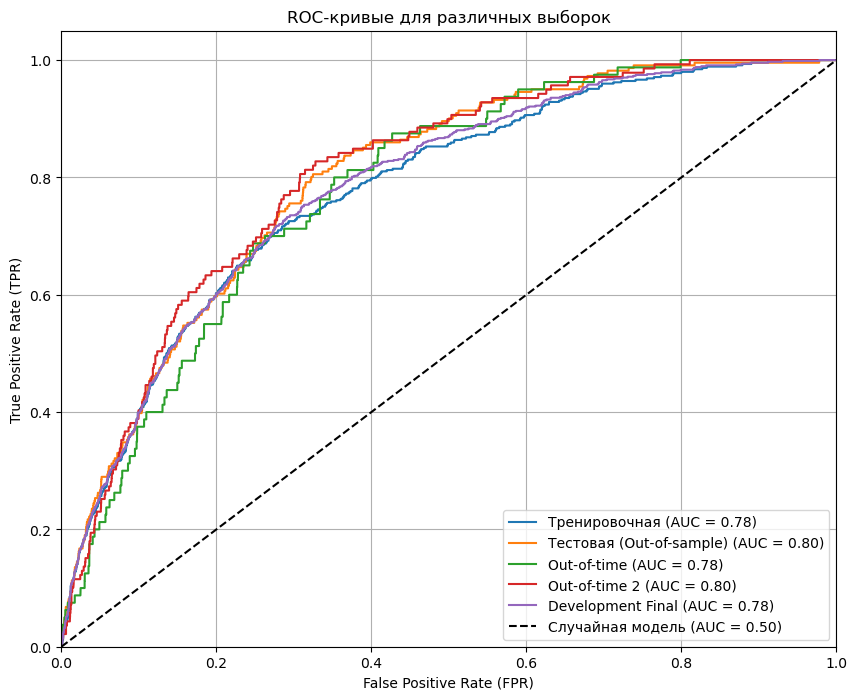

In [98]:
# Построение ROC-кривых
plt.figure(figsize=(10, 8))
plot_roc(y_train_selected, train_pred_proba, 'Тренировочная')
plot_roc(y_test_selected, test_pred_proba, 'Тестовая (Out-of-sample)')
plot_roc(y_oot_selected, oot_pred_proba, 'Out-of-time')
plot_roc(y_oot2_selected, oot2_pred_proba, 'Out-of-time 2')
plot_roc(y_dev_final_selected, dev_final_pred_proba, 'Development Final')

plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривые для различных выборок')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# -------------- Шаг 18: Сохранение результатов оценки в Excel --------------

# Создание DataFrame с ROC-AUC для различных выборок
roc_auc_df = pd.DataFrame({
    'Выборка': ['Тренировочная', 'Тестовая (Out-of-sample)', 'Out-of-time', 'Out-of-time 2', 'Development Final'],
    'ROC-AUC': [auc_train, auc_test, auc_oot, auc_oot2, auc_dev_final]
})

# Сохранение ROC-AUC в Excel
logging.info("Сохранение ROC-AUC результатов в Excel.")
roc_auc_df.to_excel("ROC_AUC_Results.xlsx", index=False)


In [99]:
# Создание DataFrame с матрицами ошибок
confusion_matrices = {
    'Тренировочная': confusion_matrix(y_train_selected, train_pred),
    'Тестовая (Out-of-sample)': confusion_matrix(y_test_selected, test_pred),
    'Out-of-time': confusion_matrix(y_oot_selected, oot_pred),
    'Out-of-time 2': confusion_matrix(y_oot2_selected, oot2_pred),
    'Development Final': confusion_matrix(y_dev_final_selected, dev_final_pred)
}

In [100]:
# Сохранение матриц ошибок в Excel
logging.info("Сохранение матриц ошибок в Excel.")
with pd.ExcelWriter('Confusion_Matrices.xlsx') as writer:
    for dataset, cm in confusion_matrices.items():
        cm_df = pd.DataFrame(cm, index=['Негативный', 'Позитивный'], columns=['Негативный', 'Позитивный'])
        cm_df.to_excel(writer, sheet_name=dataset[:31])  # Ограничение на длину имени листа в Excel

logging.info("Сохранение результатов оценки модели завершено.")


2024-12-04 14:02:59,804 - INFO - Сохранение матриц ошибок в Excel.
2024-12-04 14:02:59,841 - INFO - Сохранение результатов оценки модели завершено.


In [101]:
# -------------- Шаг 19: Сохранение модели и трансформеров --------------

logging.info("Сохранение модели и трансформеров на диск.")
joblib.dump(model_selected, 'logistic_regression_model_selected.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')
sc.woebin_save(bins_final5_M1_Employee, "M1_Employee_bins5.json")
sc.w


2024-12-04 14:03:07,243 - INFO - Сохранение модели и трансформеров на диск.


AttributeError: module 'scorecardpy' has no attribute 'woebin_save'

# Анализ важности признаков

In [ ]:
# Визуализация коэффициентов модели
coefficients_selected = coefficients_selected.sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Variable', data=coefficients_selected)
plt.title('Важность признаков по коэффициентам логистической регрессии')
plt.xlabel('Коэффициент')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


# Калибровка модели

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Обучение калиброванной модели
logging.info("Обучение калиброванной модели.")
calibrated_model = CalibratedClassifierCV(base_estimator=model_selected, method='sigmoid', cv='prefit')
calibrated_model.fit(X_train_selected_scaled, y_train_selected)

# Предсказания калиброванной модели на тестовой выборке
calibrated_test_pred_proba = calibrated_model.predict_proba(X_test_selected_scaled)[:, 1]

# Оценка калиброванной модели
auc_calibrated_test = roc_auc_score(y_test_selected, calibrated_test_pred_proba)
logging.info(f"ROC-AUC на тестовой выборке после калибровки: {auc_calibrated_test:.4f}")

# Визуализация ROC-кривой для калиброванной модели
fpr, tpr, _ = roc_curve(y_test_selected, calibrated_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Калиброванная модель (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайная модель (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая калиброванной модели')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
Регуляризация модели

In [ ]:
# Пример с регуляризацией L1 (Lasso)
logging.info("Обучение модели с регуляризацией L1.")
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train_selected_scaled, y_train_selected)

# Предсказания и оценка модели с L1 регуляризацией
train_pred_proba_l1 = model_l1.predict_proba(X_train_selected_scaled)[:, 1]
train_pred_l1 = model_l1.predict(X_train_selected_scaled)

auc_train_l1 = evaluate_model(y_train_selected, train_pred_l1, train_pred_proba_l1, "тренировочной (L1)")


In [ ]:
Кросс-валидация

In [ ]:
from sklearn.model_selection import cross_val_score

# Кросс-валидация с 5 фолдами
logging.info("Проведение кросс-валидации с 5 фолдами.")
cv_scores = cross_val_score(model_selected, X_train_selected_scaled, y_train_selected, cv=5, scoring='roc_auc')
logging.info(f"Средний ROC-AUC по кросс-валидации: {cv_scores.mean():.4f}")
logging.info(f"Стандартное отклонение ROC-AUC по кросс-валидации: {cv_scores.std():.4f}")


In [ ]:
Обработка новых данных

In [ ]:
# Пример обработки новых данных
new_data = pd.read_excel("New_Data.xlsx")

# Преобразование названий столбцов в snake_case (если необходимо)
new_data.columns = [to_snake_case(col) for col in new_data.columns]

# Применение WOE кодирования
new_data_woe = sc.woebin_ply(new_data, bins_loaded)

# Выбор отобранных признаков
X_new = new_data_woe[selected_features_stepwise]

# Преобразование категориальных признаков с помощью One-Hot Encoding
X_new = pd.get_dummies(X_new, drop_first=True)

# Убедиться, что все признаки присутствуют
missing_cols_new = set(selected_features_stepwise) - set(X_new.columns)
for c in missing_cols_new:
    X_new[c] = 0
X_new = X_new[selected_features_stepwise]

# Обработка пропусков
X_new_imputed = imputer_loaded.transform(X_new)

# Масштабирование
X_new_scaled = scaler_loaded.transform(X_new_imputed)

# Предсказание вероятностей
new_pred_proba = model_loaded.predict_proba(X_new_scaled)[:, 1]
new_pred = model_loaded.predict(X_new_scaled)

# Добавление предсказаний к данным
new_data['Predicted_Prob'] = new_pred_proba
new_data['Predicted_Class'] = new_pred

# Сохранение результатов
new_data.to_excel("New_Data_With_Predictions.xlsx", index=False)
